In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as pil_image
sns.set_style('white')
%matplotlib inline

from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.preprocessing import image
from keras.layers import AveragePooling2D, Conv2D, UpSampling2D
from keras.models import load_model, Model
from utils.keras_utils import preprocess_input_tf, center_crop

import itertools
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score


Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes, figname=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=(7,7))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '%.2f' % cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=16)
        else:
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=16)
    plt.tight_layout()
    #plt.ylabel('True label', fontsize=20)
    #plt.xlabel('Predicted label', fontsize=20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if title is not None:
        plt.title(title)
    # plt.colorbar()
    if figname is None:
        plt.show()
    else:
        plt.savefig(figname)
        plt.close()

In [3]:
def plot_stats(y_true, y_pred, n_class=4):
    col = sns.color_palette()

    fig, axarr = plt.subplots(n_class, n_class, sharex=True, figsize=(10,10))
    for i_true in range(n_class):
        v = y_pred[y_true == i_true]
        for j_pred in range(n_class):
            axarr[i_true, j_pred].hist(v[:, j_pred], 10, normed=False, color=col[i_true])
            axarr[i_true, j_pred].set_title('class=%d, prediction=%d' % (i_true, j_pred))
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.tight_layout()
    plt.show()


In [4]:
def get_filenames_and_classes(csv_path):
    df = pd.read_csv(csv_path, sep='\t', index_col=0)
    filenames, classes = [], []
    for base_name, primary_grade, sec_grade in zip(df.index, df.iloc[:,0], df.iloc[:,1]):
        primary_grade, sec_grade = int(primary_grade), int(sec_grade)
        filenames.append(base_name)
        classes.append(np.array([primary_grade, sec_grade]).reshape(1,2))
    classes = np.vstack(classes)
    return filenames, classes


In [5]:
init_dim = 250
target_dim = 224
target_size = (target_dim, target_dim)
input_shape = (target_size[0], target_size[1], 3)
bs = 32

# classes
class_labels = ['Benign', 'Gleason 3', 'Gleason 4', 'Gleason 5']
n_class = len(class_labels)
prefix = '/data3/eirini/dataset_TMA'
patch_dir = os.path.join(prefix, 'train_validation_patches_750')

In [6]:
# validation set
tma = 'ZT76'
csv_path = os.path.join(prefix, 'tma_info', '%s_gleason_scores.csv' % tma)
val_filenames, val_classes = get_filenames_and_classes(csv_path)
print('Total TMAs in validation set: %d' % len(val_filenames))

Total TMAs in validation set: 133


In [7]:
# load model
model_weights = 'model_weights/MobileNet_Gleason_weights.h5'
model = load_model(model_weights,
                   custom_objects={'relu6': relu6,
                                   'DepthwiseConv2D': DepthwiseConv2D
                                  })

# define an ouput directory for plots
outdir = '/data3/eirini/TMA_results/plots'

In [8]:
# compute confusion matrix for validation set
val_patch_names = []
val_patch_labels = []
for val_subdir in val_filenames:
    subpath = os.path.join(patch_dir, val_subdir)
    for fname in os.listdir(subpath):
        if fname.lower().endswith('.jpg'):
            val_patch_names.append(os.path.join(subpath, fname))
            y = int(fname.split('_')[-1].rstrip('.jpg'))
            val_patch_labels.append(y)
n_patch = len(val_patch_names)

y_pred_prob = np.zeros((n_patch, n_class))
for i, patch_name in enumerate(val_patch_names):
    img = image.load_img(patch_name, grayscale=False, target_size=(init_dim, init_dim))
    X = image.img_to_array(img)
    X = center_crop(X, center_crop_size=target_size)
    X = preprocess_input_tf(X)
    y_pred_prob[i] = model.predict(X[np.newaxis,:,:,:], batch_size=1)[0]

y_true = np.array(val_patch_labels)
y_pred = np.argmax(y_pred_prob, axis=1)

In [9]:
kappa_val = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print('%.2f' % kappa_val)

0.67


In [10]:
# plot_stats(y_true, y_pred_prob)

[[ 0.62612613  0.16966967  0.10810811  0.0960961 ]
 [ 0.02925244  0.71830986  0.23293608  0.01950163]
 [ 0.008726    0.23560209  0.58464223  0.17102967]
 [ 0.01875     0.0125      0.090625    0.878125  ]]


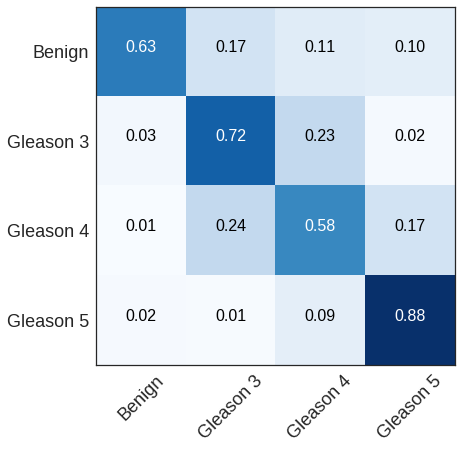

In [11]:

# figname = os.path.join(outdir, 'validation_patch_based.eps')
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_labels, figname=None, normalize=True)


In [12]:
# test filenames
test_patch_dir = os.path.join(prefix, 'test_patches_750', 'patho_1')
test_filenames = [f for f in os.listdir(test_patch_dir) if f.startswith('ZT80')]
len(test_filenames)

245

In [14]:
patches_csv_path = os.path.join(prefix, 'tma_info', 'ZT80_patch_grades.csv')
df_patch = pd.read_csv(patches_csv_path, sep='\t', index_col=0)
true_grades = df_patch.values

# make predictions on test cohort patches
y_pred_prob = np.zeros((df_patch.shape[0], n_class))
for i, (patch_name, y_true) in enumerate(zip(df_patch.index, df_patch.iloc[:,0])):
    spot_name = patch_name.split('_patch_')[0]
    full_name = os.path.join(test_patch_dir, spot_name, patch_name+'_class_%d.jpg' % y_true)
    img = image.load_img(full_name, grayscale=False, target_size=(init_dim, init_dim))
    X = image.img_to_array(img)
    X = center_crop(X, center_crop_size=target_size)
    X = preprocess_input_tf(X)
    y_pred_prob[i] = model.predict(X[np.newaxis,:,:,:], batch_size=1)[0]

y_pred = np.argmax(y_pred_prob, axis=1)

[[ 0.42519685  0.4488189   0.09448819  0.03149606]
 [ 0.01310861  0.54307116  0.41697878  0.02684145]
 [ 0.00754361  0.12588402  0.70391325  0.16265912]
 [ 0.00516796  0.03617571  0.30749354  0.65116279]]


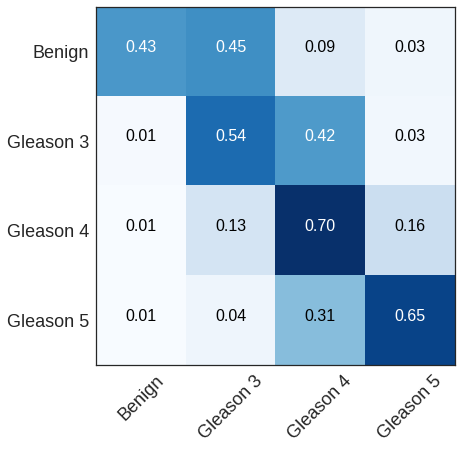

0.55


In [15]:
# compute confusion matrix for test set - CNN vs first pathologist's annotations

# figname = os.path.join(outdir, 'CNN_vs_patho1_patch_based.eps')
cm = confusion_matrix(true_grades[:,0], y_pred)
plot_confusion_matrix(cm, class_labels, figname=None, normalize=True)

kappa_p1 = cohen_kappa_score(true_grades[:,0], y_pred, weights='quadratic')
print('%.2f' % kappa_p1)

[[ 0.42222222  0.47777778  0.08888889  0.01111111]
 [ 0.03832753  0.6213705   0.31591173  0.02439024]
 [ 0.00662983  0.21804788  0.64088398  0.13443831]
 [ 0.00700525  0.06654991  0.47635727  0.45008757]]


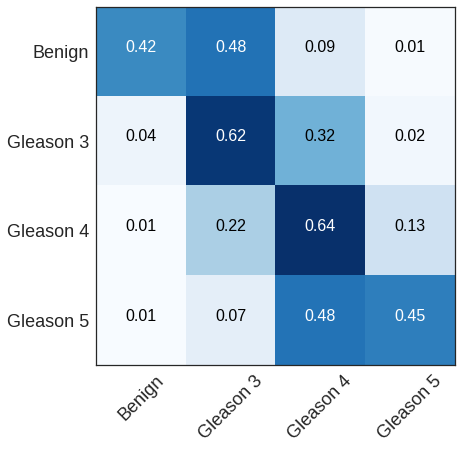

0.49


In [16]:
# compute confusion matrix for test set - CNN vs second pathologist's annotations

# figname = os.path.join(outdir, 'CNN_vs_patho2_patch_based.eps')
cm = confusion_matrix(true_grades[:,1], y_pred)
plot_confusion_matrix(cm, class_labels, figname=None, normalize=True)

kappa_p2 = cohen_kappa_score(true_grades[:,1], y_pred, weights='quadratic')
print('%.2f' % kappa_p2)

[[ 0.70866142  0.29133858  0.          0.        ]
 [ 0.          0.46816479  0.53183521  0.        ]
 [ 0.          0.0348892   0.84111268  0.12399811]
 [ 0.          0.          0.20413437  0.79586563]]


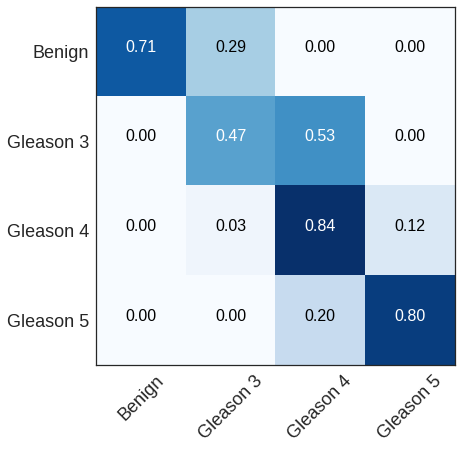

0.67


In [17]:
# inter-pathologist variability
cm = confusion_matrix(true_grades[:,0], true_grades[:,1])
# figname = os.path.join(outdir, 'patho1_patho2.eps')
plot_confusion_matrix(cm, class_labels, figname=None, normalize=True)

#cm = confusion_matrix(true_grades[:,1], true_grades[:,0])
#figname = os.path.join(outdir, 'patho2_patho1.eps')
#plot_confusion_matrix(cm, class_labels, figname=None, normalize=True)

kappa_p1_p2 = cohen_kappa_score(true_grades[:,0], true_grades[:,1], weights='quadratic')
print('%.2f' % kappa_p1_p2)

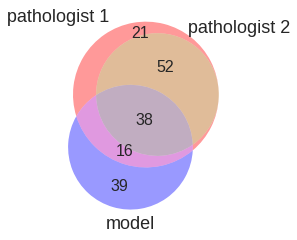

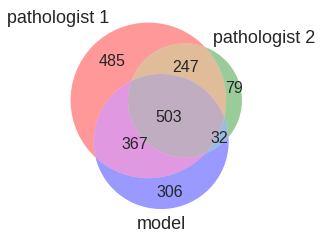

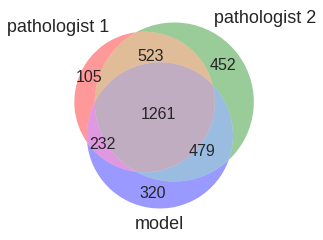

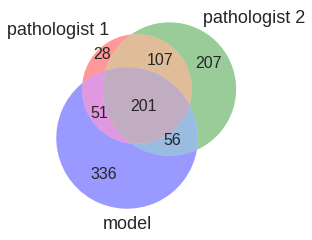

In [18]:
# Venn diagrams
from matplotlib_venn import venn3
sns.set_palette(sns.color_palette("Set2", 8))
for i in range(n_class):
    set_patho1 = set(df_patch.index[true_grades[:,0] == i])
    set_patho2 = set(df_patch.index[true_grades[:,1] == i])
    set_CNN = set(df_patch.index[y_pred == i])
    
    plt.figure()
    v = venn3([set_patho1, set_patho2, set_CNN], ['pathologist 1', 'pathologist 2', 'model'])
    for text in v.set_labels:
        text.set_fontsize(18)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(16)
    plt.show()
    #plt.savefig(os.path.join(outdir, 'venn3_class_%d.pdf' % i))
    #plt.close()

In [19]:
def assign_group(a, b, survival_groups=False):
    # if both cancer and benign tissue are predicted
    # ignore benign tissue for reporting, as pathologists do
    if (a > 0) and (b == 0):
        b = a
    if (b > 0) and (a == 0):
        a = b

    if not survival_groups:
        return a + b
    else:
        # get the actual Gleason pattern (range 3-5)
        a += 2
        b += 2
        if a+b <= 6:
            return 1
        elif a+b == 7:
            return 2
        else:
            return 3
    
def gleason_summary_wsum(y_pred, survival_groups=False, thres=None):
    gleason_scores = y_pred.copy()
    gleason_scores /= np.sum(gleason_scores)
    # remove outlier predictions
    if thres is not None:
        gleason_scores[gleason_scores < thres] = 0
    # and assign overall grade
    idx = np.argsort(gleason_scores)[::-1]
    primary_class = idx[0]
    secondary_class = idx[1] if gleason_scores[idx[1]] > 0 else idx[0]
    return assign_group(primary_class, secondary_class, survival_groups)

def pil_resize(img, target_size):
    hw_tuple = (target_size[1], target_size[0])
    if img.size != hw_tuple:
        img = img.resize(hw_tuple)
    return img

In [20]:
# Compute model predictions (pixel-level probability maps) 

w_out, b_out = model.layers[-1].get_weights()
w_out = w_out[np.newaxis,np.newaxis,:,:]

# rescaling factor is 3
big_dim = 1024
base_model = MobileNet(include_top=False, weights=None,
                       input_shape=(big_dim, big_dim, 3),
                       alpha=.5, depth_multiplier=1, dropout=.2)
block_name = 'conv_pw_13_relu'
x_input = base_model.get_layer(block_name).output

# average pooling instead of global pooling
x = AveragePooling2D((7, 7), strides=(1,1), padding='same', name='avg_pool_top')(x_input)
x = Conv2D(n_class, (1, 1), activation='softmax', padding='same')(x)
x_out = UpSampling2D(size=(32, 32), name='upsample')(x)
big_model = Model(base_model.input, x_out)
big_model.load_weights(model_weights, by_name=True)
big_model.layers[-2].set_weights([w_out, b_out])

In [21]:
# Make predictions on entire TMA spots for the validation cohort.

image_dir = os.path.join(prefix, 'TMA_images')
mask_dir = os.path.join(prefix, 'tissue_masks')
D_val = dict()

for fname in val_filenames:
    full_imfile = os.path.join(image_dir, fname+'.jpg')
    # get network predictions as heatmap
    img = image.load_img(full_imfile, grayscale=False, target_size=(big_dim, big_dim))
    X = image.img_to_array(img)
    X = preprocess_input_tf(X)
    y_pred_prob = big_model.predict(X[np.newaxis,:,:,:], batch_size=1)[0]
    
    # get the (automatically generated) tissue mask
    tissue_maskfile = os.path.join(mask_dir, 'mask_'+fname+'.png')
    tissue_mask = pil_image.open(tissue_maskfile)
    tissue_mask = np.array(pil_resize(tissue_mask, target_size=(big_dim, big_dim)))

    # compute probability only at (predicted) tissue regions
    y_pred_prob[tissue_mask == n_class] = 0.
    y_pred_prob = y_pred_prob.reshape(-1, 4)
    w_sum = np.sum(y_pred_prob, axis=0)
    D_val[fname] = w_sum

Found annotation for 133 out of 133 TMA spots.
CNN-pathologist 1: 0.72
[[24 11  2  2  1  2]
 [ 0 22  9  3  1  0]
 [ 0  8 17  0  0  0]
 [ 0  1  5  5  4  0]
 [ 0  0  0  0  2  0]
 [ 0  0  1  0  7  6]]


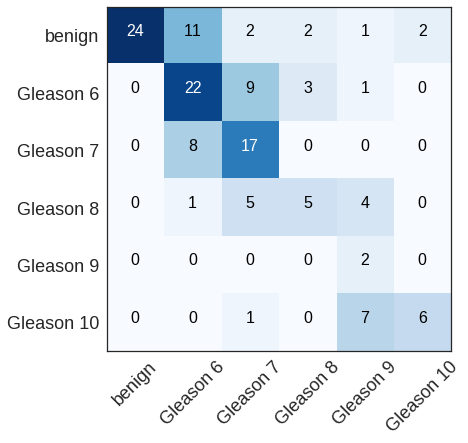

In [22]:
# Compute confusion matrices and Cohen's kappa statistic for Gleason score assignments on entire TMA spots
# (validation cohort)

N = len(D_val.keys())
csv_file = os.path.join(prefix, 'tma_info', 'ZT76_gleason_scores.csv')
df_patho = pd.read_csv(csv_file, sep='\t', index_col=0)

# load training data survival times
ii = 0
x_gleason_cnn = np.zeros(N)
x_gleason_annot_patho1 = np.zeros(N)
case_ids = []

for fname in D_val.keys():
    # if the image was annotated by the pathologists
    if fname in df_patho.index:
        a, b = df_patho.loc[fname][['class_primary', 'class_secondary']]
        x_gleason_annot_patho1[ii] = assign_group(a, b)
        x_gleason_cnn[ii] = gleason_summary_wsum(D_val[fname], thres=0.25)
        case_ids.append(fname)
        ii += 1
    
# discard unused part of matrices
set_cnn = x_gleason_cnn[:ii]
set_patho1 = x_gleason_annot_patho1[:ii]
print('Found annotation for %d out of %d TMA spots.' % (ii, N))

# compute kappa values
kappa_p1 = cohen_kappa_score(set_patho1, set_cnn, weights='quadratic')
print('CNN-pathologist 1: %.2f' % kappa_p1)

classes = ['benign', 'Gleason 6', 'Gleason 7', 'Gleason 8', 'Gleason 9', 'Gleason 10']
# figname = os.path.join(outdir, 'validation_TMA_based.eps')
cm = confusion_matrix(set_patho1, set_cnn)
plot_confusion_matrix(cm, classes, figname=None, normalize=False)


In [23]:
# Make predictions on entire TMA spots for the test cohort.

image_dir = os.path.join(prefix, 'TMA_images')
mask_dir = os.path.join(prefix, 'tissue_masks')
D = dict()

for fname in test_filenames:
    full_imfile = os.path.join(image_dir, fname+'.jpg')
    # get network predictions as heatmap
    img = image.load_img(full_imfile, grayscale=False, target_size=(big_dim, big_dim))
    X = image.img_to_array(img)
    X = preprocess_input_tf(X)
    y_pred_prob = big_model.predict(X[np.newaxis,:,:,:], batch_size=1)[0]
    
    # get the (automatically generated) tissue mask
    tissue_maskfile = os.path.join(mask_dir, 'mask_'+fname+'.png')
    tissue_mask = pil_image.open(tissue_maskfile)
    tissue_mask = np.array(pil_resize(tissue_mask, target_size=(big_dim, big_dim)))

    # compute probability only at (predicted) tissue regions
    y_pred_prob[tissue_mask == n_class] = 0.
    y_pred_prob = y_pred_prob.reshape(-1, 4)
    w_sum = np.sum(y_pred_prob, axis=0)
    D[fname] = w_sum

Found annotation for 245 out of 245 TMA spots.
inter-pathologist: 0.71
CNN-pathologist 1: 0.75
CNN-pathologist 2: 0.71
[[ 6  6  0  0  0  0]
 [ 0 32 46  1  0  0]
 [ 0  3 28 19  1  0]
 [ 0  0 27 37 20  0]
 [ 0  0  1  5  1  0]
 [ 0  0  0  0 11  1]]


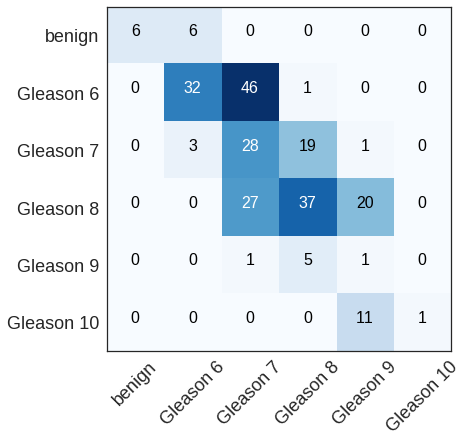

[[ 6  4  0  0  0  0]
 [ 0 17 12  1  0  0]
 [ 0 19 52 11  0  0]
 [ 0  1 29 37 17  0]
 [ 0  0  8 13  4  0]
 [ 0  0  1  0 12  1]]


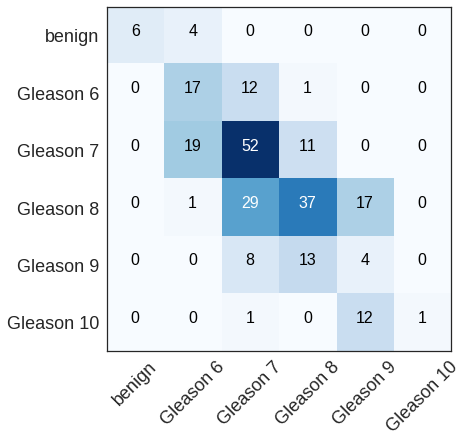

[[10  2  0  0  0  0]
 [ 0 23 45 11  0  0]
 [ 0  3 23 19  6  0]
 [ 0  2 14 48 17  3]
 [ 0  0  0  4  2  1]
 [ 0  0  0  2  0 10]]


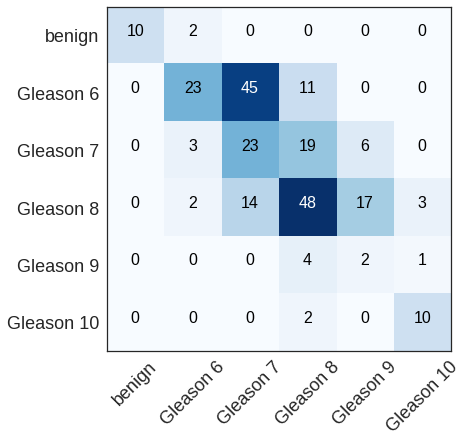

In [24]:
# Compute confusion matrices and Cohen's kappa statistic for Gleason score assignments on entire TMA spots
# (test cohort)

N = len(D.keys())
csv_file = os.path.join(prefix, 'tma_info', 'ZT80_gleason_scores.csv')
df_patho = pd.read_csv(csv_file, sep='\t', index_col=0)

ii = 0
x_gleason_cnn = np.zeros(N)
x_gleason_annot_patho1 = np.zeros(N)
x_gleason_annot_patho2 = np.zeros(N)
case_ids = []

for fname in D.keys():
    # if the image was annotated by the pathologists
    if fname in df_patho.index:
        a, b = df_patho.loc[fname][['patho1_class_primary', 'patho1_class_secondary']]
        x_gleason_annot_patho1[ii] = assign_group(a, b)
        a, b = df_patho.loc[fname][['patho2_class_primary', 'patho2_class_secondary']]
        x_gleason_annot_patho2[ii] = assign_group(a, b)
        x_gleason_cnn[ii] = gleason_summary_wsum(D[fname], thres=0.25)
        case_ids.append(fname)
        ii += 1
    
# discard unused part of matrices
set_cnn = x_gleason_cnn[:ii]
set_patho1 = x_gleason_annot_patho1[:ii]
set_patho2 = x_gleason_annot_patho2[:ii]
print('Found annotation for %d out of %d TMA spots.' % (ii, N))

# compute kappa values
kappa_p1_p2 = cohen_kappa_score(set_patho1, set_patho2, weights='quadratic')
print('inter-pathologist: %.2f' % kappa_p1_p2)
kappa_p1 = cohen_kappa_score(set_patho1, set_cnn, weights='quadratic')
print('CNN-pathologist 1: %.2f' % kappa_p1)
kappa_p2 = cohen_kappa_score(set_patho2, set_cnn, weights='quadratic')
print('CNN-pathologist 2: %.2f' % kappa_p2)

# confusion matrices
classes = ['benign', 'Gleason 6', 'Gleason 7', 'Gleason 8', 'Gleason 9', 'Gleason 10']

#figname = os.path.join(outdir, 'CNN_vs_patho1_TMA_based.eps')
cm = confusion_matrix(set_patho1, set_cnn)
plot_confusion_matrix(cm, classes, figname=None, normalize=False)

#figname = os.path.join(outdir, 'CNN_vs_patho2_TMA_based.eps')
cm = confusion_matrix(set_patho2, set_cnn)
plot_confusion_matrix(cm, classes, figname=None, normalize=False)

#figname = os.path.join(outdir, 'patho1_vs_patho2_TMA_based.eps')
cm = confusion_matrix(set_patho1, set_patho2)
plot_confusion_matrix(cm, classes, figname=None, normalize=False)